In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch import optim
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Подготовка датасета

### Кодирование строковых признаков

In [13]:
steel_industry_energy_consumption = fetch_ucirepo(id=851)

# data (as pandas dataframes)
X = steel_industry_energy_consumption.data.features
y = steel_industry_energy_consumption.data.targets

encoder = LabelEncoder()
encoder.fit_transform(X['WeekStatus'].to_frame())
X['WeekStatus'] = encoder.transform(X['WeekStatus'].to_frame())

encoder = LabelEncoder()
encoder.fit_transform(X['Day_of_week'].to_frame())
X['Day_of_week'] = encoder.transform(X['Day_of_week'].to_frame())

encoder = LabelEncoder()
encoder.fit_transform(y['Load_Type'].to_frame())
y['Load_Type'] = encoder.transform(y['Load_Type'].to_frame())

dataset = X
dataset['Load_Type'] = y['Load_Type']
dataset.to_csv('kw_dataset.csv', index=False) # сохраняем на случай если будет нужно вернуться от заскейленных значений к исходным

### Нормализация данных

In [15]:
dataset = pd.read_csv('kw_dataset.csv')

for column in dataset.columns:
    scaler = MinMaxScaler()
    scaler.fit_transform(dataset[column].to_frame())
    dataset[column] = scaler.transform(dataset[column].to_frame())

dataset.head()

### Подготовка обучающей и тестовой выборок

In [16]:
X = dataset.drop(columns=['Usage_kWh'])
y = dataset['Usage_kWh'].values

X = np.expand_dims(X.to_numpy().astype(float), axis=1)
y = np.expand_dims(y.astype(float), axis=1)
split_ratio = int(y.shape[0]*0.8)
X_train = X[:split_ratio].astype(float)
X_test = X[split_ratio:].astype(float)
y_train = y[:split_ratio].astype(float)
y_test = y[split_ratio:].astype(float)

print(f'X_train.shape={X_train.shape}')
print(f'X_test.shape={X_test.shape}')
print(f'y_train.shape={y_train.shape}')
print(f'y_test.shape={y_test.shape}')

### Подготовка обучающего датасета и лоадера

In [17]:
dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)
print('Loader created')

## Реализация моделей - RNN, GRU, LSTM

In [19]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)).to(device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRU, self).__init__()
        self.hidden_size = hidden_dim
        self.num_layers = layer_dim
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_dim
        self.num_layers = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=device)
        out, _ = self.lstm(x, (h0, c0))
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

### Инициализация параметров моделей

In [21]:
input_dim = 9    # input dimension
hidden_dim = 50  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 1   # output dimension
device = 'cuda'

### Обучение моделей

# LSTM

In [64]:
lstm_model = LSTM(input_dim, hidden_dim, layer_dim, output_dim).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.L1Loss()

progress_bar = tqdm(list(np.arange(epochs)), desc="Epoch", colour="white")
info_bar = {"Loss": 0}

losses = []
for epoch in range(epochs):
    loss = 0
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(train_features)
        train_loss = criterion(outputs, test_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(dataloader)
    losses.append(loss)
    info_bar['Loss'] = np.round(loss, 5)
    progress_bar.update()
    progress_bar.set_postfix_str(info_bar)
    #print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
torch.save(lstm_model.state_dict(), '__lstm_300_norm.pt')

Epoch: 100%|███████████████████████████████████████████████████████| 300/300 [02:42<00:00,  1.82it/s, {'Loss': 0.0082}]

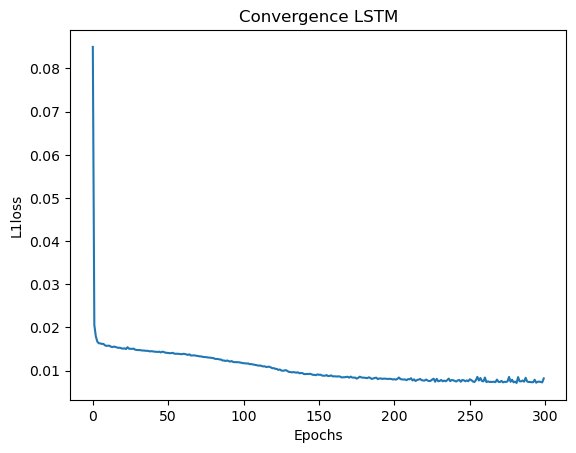

In [65]:
plt.plot(np.arange(epochs), losses)
plt.title('Convergence LSTM')
plt.ylabel('L1loss')
plt.xlabel('Epochs')
plt.show()

# GRU

In [92]:
gru_model = GRU(input_dim, hidden_dim, layer_dim, output_dim).to(device)
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
criterion = nn.L1Loss()

progress_bar = tqdm(list(np.arange(epochs)), desc="Epoch", colour="white")
info_bar = {"Loss": 0}

losses = []
for epoch in range(epochs):
    loss = 0
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)
        optimizer.zero_grad()
        outputs = gru_model(train_features)
        train_loss = criterion(outputs, test_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(dataloader)
    losses.append(loss)
    info_bar['Loss'] = np.round(loss, 5)
    progress_bar.update()
    progress_bar.set_postfix_str(info_bar)
    #print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
torch.save(gru_model.state_dict(), '__gru_300_norm.pt')

Epoch: 100%|██████████████████████████████████████████████████████| 300/300 [02:40<00:00,  1.89it/s, {'Loss': 0.00849}]

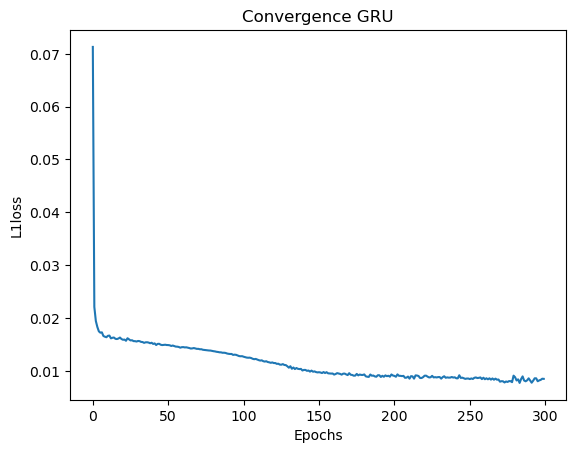

In [93]:
plt.plot(np.arange(epochs), losses)
plt.title('Convergence GRU')
plt.ylabel('L1loss')
plt.xlabel('Epochs')
plt.show()

# RNN

In [70]:
rnn_model = RNN(input_dim, hidden_dim, layer_dim, output_dim).to(device)
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
criterion = nn.L1Loss()

progress_bar = tqdm(list(np.arange(epochs)), desc="Epoch", colour="white")
info_bar = {"Loss": 0}

losses = []
for epoch in range(epochs):
    loss = 0
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)
        optimizer.zero_grad()
        outputs = rnn_model(train_features)
        train_loss = criterion(outputs, test_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(dataloader)
    losses.append(loss)
    info_bar['Loss'] = np.round(loss, 5)
    progress_bar.update()
    progress_bar.set_postfix_str(info_bar)
    #print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
torch.save(rnn_model.state_dict(), '__rnn_300_norm.pt')

Epoch: 100%|██████████████████████████████████████████████████████| 300/300 [02:40<00:00,  1.84it/s, {'Loss': 0.00677}]

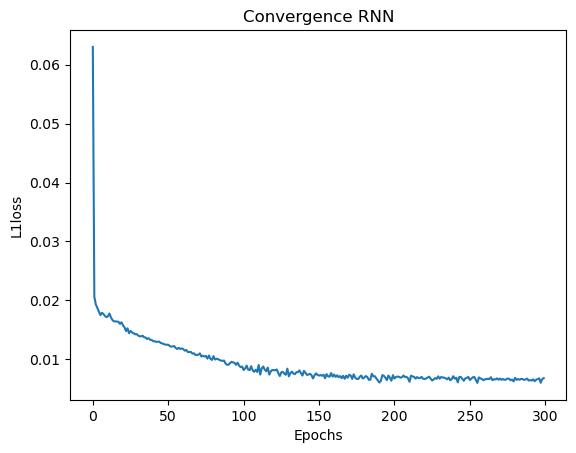

In [71]:
plt.plot(np.arange(epochs), losses)
plt.title('Convergence RNN')
plt.ylabel('L1loss')
plt.xlabel('Epochs')
plt.show()

## Оценка качества на отложенной выборке

In [72]:
model = LSTM(input_dim, hidden_dim, layer_dim, output_dim).to(device)
model.load_state_dict(torch.load('__lstm_300_norm.pt'))
model.eval()

test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_set_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
print('Loader created')

r2_losses = []
mse_losses = []
rmse_losses = []
for x, y in test_set_loader:
    x = x.to(device)
    x_hat = model(x)
    output = x_hat.detach().cpu().numpy()
    target = y.detach().cpu().numpy()
    r2_test = r2_score(target, output)
    mse_test = mean_squared_error(target, output)
    rmse_test = root_mean_squared_error(target, output)

    r2_losses.append(r2_test)
    mse_losses.append(mse_test)
    rmse_losses.append(rmse_test)

lstm_r2 = round(np.nanmean(r2_losses), 5)
lstm_mse = round(float(np.nanmean(mse_losses)), 5)
lstm_rmse = round(float(np.nanmean(rmse_losses)), 5)

print(f'LSTM R2={lstm_r2}')
print(f'LSTM MSE={lstm_mse}')
print(f'LSTM RMSE={lstm_rmse}')

Loader created
LSTM R2=0.78067
LSTM MSE=0.00011
LSTM RMSE=0.00976


In [94]:
model = GRU(input_dim, hidden_dim, layer_dim, output_dim).to(device)
model.load_state_dict(torch.load('__gru_300_norm.pt'))
model.eval()

test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_set_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
print('Loader created')

r2_losses = []
mse_losses = []
rmse_losses = []
for x, y in test_set_loader:
    x = x.to(device)
    x_hat = model(x)
    output = x_hat.detach().cpu().numpy()
    target = y.detach().cpu().numpy()
    r2_test = r2_score(target, output)
    mse_test = mean_squared_error(target, output)
    rmse_test = root_mean_squared_error(target, output)

    r2_losses.append(r2_test)
    mse_losses.append(mse_test)
    rmse_losses.append(rmse_test)

gru_r2 = round(np.nanmean(r2_losses), 5)
gru_mse = round(float(np.nanmean(mse_losses)), 5)
gru_rmse = round(float(np.nanmean(rmse_losses)), 5)

print(f'GRU R2={gru_r2}')
print(f'GRU MSE={gru_mse}')
print(f'GRU RMSE={gru_rmse}')

Loader created
GRU R2=0.52263
GRU MSE=0.00014
GRU RMSE=0.01081


In [74]:
model = RNN(input_dim, hidden_dim, layer_dim, output_dim).to(device)
model.load_state_dict(torch.load('__rnn_300_norm.pt'))
model.eval()

test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_set_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
print('Loader created')

r2_losses = []
mse_losses = []
rmse_losses = []
for x, y in test_set_loader:
    x = x.to(device)
    x_hat = model(x)
    output = x_hat.detach().cpu().numpy()
    target = y.detach().cpu().numpy()
    r2_test = r2_score(target, output)
    mse_test = mean_squared_error(target, output)
    rmse_test = root_mean_squared_error(target, output)

    r2_losses.append(r2_test)
    mse_losses.append(mse_test)
    rmse_losses.append(rmse_test)

rnn_r2 = round(np.nanmean(r2_losses), 5)
rnn_mse = round(float(np.nanmean(mse_losses)), 5)
rnn_rmse = round(float(np.nanmean(rmse_losses)), 5)

print(f'RNN R2={rnn_r2}')
print(f'RNN MSE={rnn_mse}')
print(f'RNN RMSE={rnn_rmse}')

Loader created
RNN R2=0.78726
RNN MSE=7e-05
RNN RMSE=0.00746


## Визуализация результатов

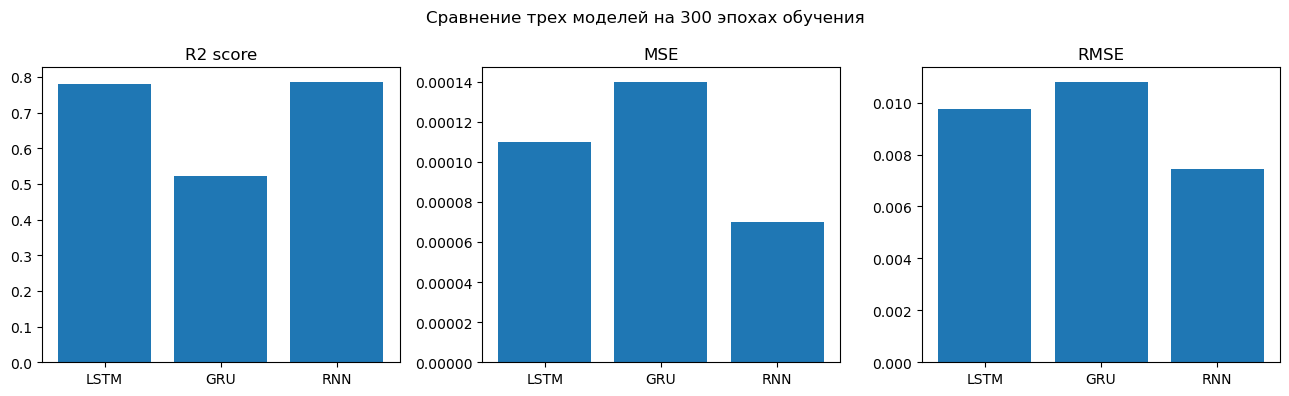

In [95]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
axs[0].bar(['LSTM', 'GRU', 'RNN'], [lstm_r2, gru_r2, rnn_r2])
axs[0].set_title('R2 score')
axs[1].bar(['LSTM', 'GRU', 'RNN'], [lstm_mse, gru_mse, rnn_mse])
axs[1].set_title('MSE')
axs[2].bar(['LSTM', 'GRU', 'RNN'], [lstm_rmse, gru_rmse, rnn_rmse])
axs[2].set_title('RMSE')
plt.suptitle('Сравнение трех моделей на 300 эпохах обучения')
plt.tight_layout()
plt.show()

### ***Таким образом, в данной постановке при одинаковых параметрах обучения модель RNN показывает лучшее качество по мерикам RMSE, MSE и R2***